# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm.auto import tqdm

# Data

In [4]:
import os, cv2

In [5]:
X = []
y = []

for digit in tqdm(os.listdir('../Data/devanagri/numerals/')):
    for img in os.listdir(f'../Data/devanagri/numerals/{digit}'):
        i = plt.imread(f'../Data/devanagri/numerals/{digit}/{img}', 0)
        X.append(i)
        y.append(digit)
        
X = np.array(X)
y = np.array(y)

p = np.random.permutation(len(X))
X, y =  X[p], y[p]

In [6]:
print('Data Set')
print(len(X))
print(X.shape)
print(y.shape)

Data Set
2880
(2880, 28, 28)
(2880,)


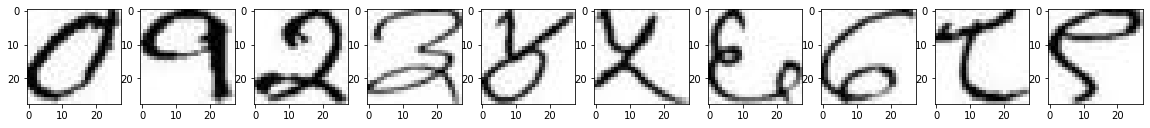

In [7]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X[y == str(i)][0],cmap=plt.get_cmap('gray'))

In [8]:
def pad_img(img, pad_size=3):
    return (cv2.resize(
        cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=255), 
        (28, 28)
    ))

In [9]:
X_cpy = X
X = []
for img in X_cpy:
    X.append(pad_img(img))
X = np.array(X)

In [10]:
X = X.astype('float32')
X /= 255.0

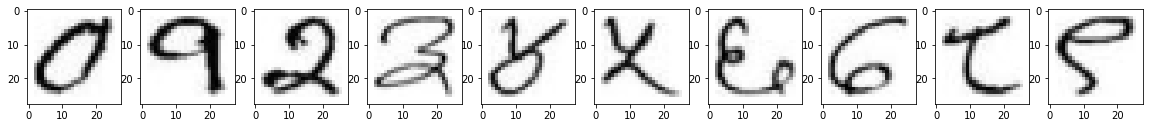

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for i in range(10):
    ax[i].imshow(X[y == str(i)][0],cmap=plt.get_cmap('gray'))

# Preparation

In [12]:
X = X.reshape(-1, 28, 28, 1)
y = pd.get_dummies(y).values
print(X.shape)
print(y.shape)

(2880, 28, 28, 1)
(2880, 10)


# Model Fitting

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Convolutional Neural Network

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
filepath = "lens-ddigi.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(patience=2)

def cnn(image_size):
    classifier = Sequential()
    classifier.add(Conv2D(32, (5, 5), input_shape = (*image_size, 1), activation = 'relu', padding='same'))
    classifier.add(Conv2D(32, (5, 5), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.25))
    classifier.add(Flatten())
    classifier.add(Dense(units = 10, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    return classifier


model = cnn((28,28))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

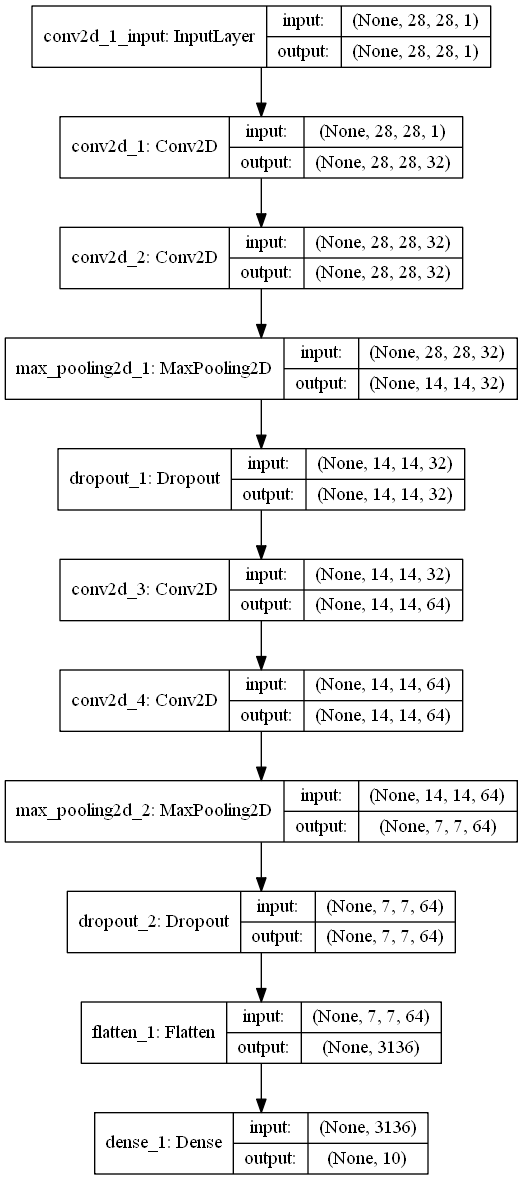

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range = 0.1,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    validation_split=0.1
)  

datagen.fit(X)

training_set = datagen.flow(
    x=X, y=y,
    subset='training'
)

validation_set = datagen.flow(
    x=X, y=y,
    subset='validation'
)

In [18]:
history = model.fit_generator(
    training_set, steps_per_epoch=1782 ,validation_data=validation_set, epochs=1000, callbacks=[es, ckpt, rlp]
)

Epoch 1/1000
1782/1782 [==============================] - 567s 318ms/step - loss: 0.2626 - accuracy: 0.9091 - val_loss: 0.0529 - val_accuracy: 0.9757

Epoch 00001: val_loss improved from inf to 0.05288, saving model to lens-ddigi.h5
Epoch 2/1000
1782/1782 [==============================] - 572s 321ms/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.0032 - val_accuracy: 0.9861

Epoch 00002: val_loss improved from 0.05288 to 0.00323, saving model to lens-ddigi.h5
Epoch 3/1000
1782/1782 [==============================] - 662s 371ms/step - loss: 0.0298 - accuracy: 0.9903 - val_loss: 0.0511 - val_accuracy: 0.9757

Epoch 00003: val_loss did not improve from 0.00323
Epoch 4/1000
1782/1782 [==============================] - 646s 363ms/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.0181 - val_accuracy: 0.9931

Epoch 00004: val_loss did not improve from 0.00323
Epoch 5/1000
1782/1782 [==============================] - 633s 355ms/step - loss: 0.0061 - accuracy: 0.9980 - val_loss: 5.8389

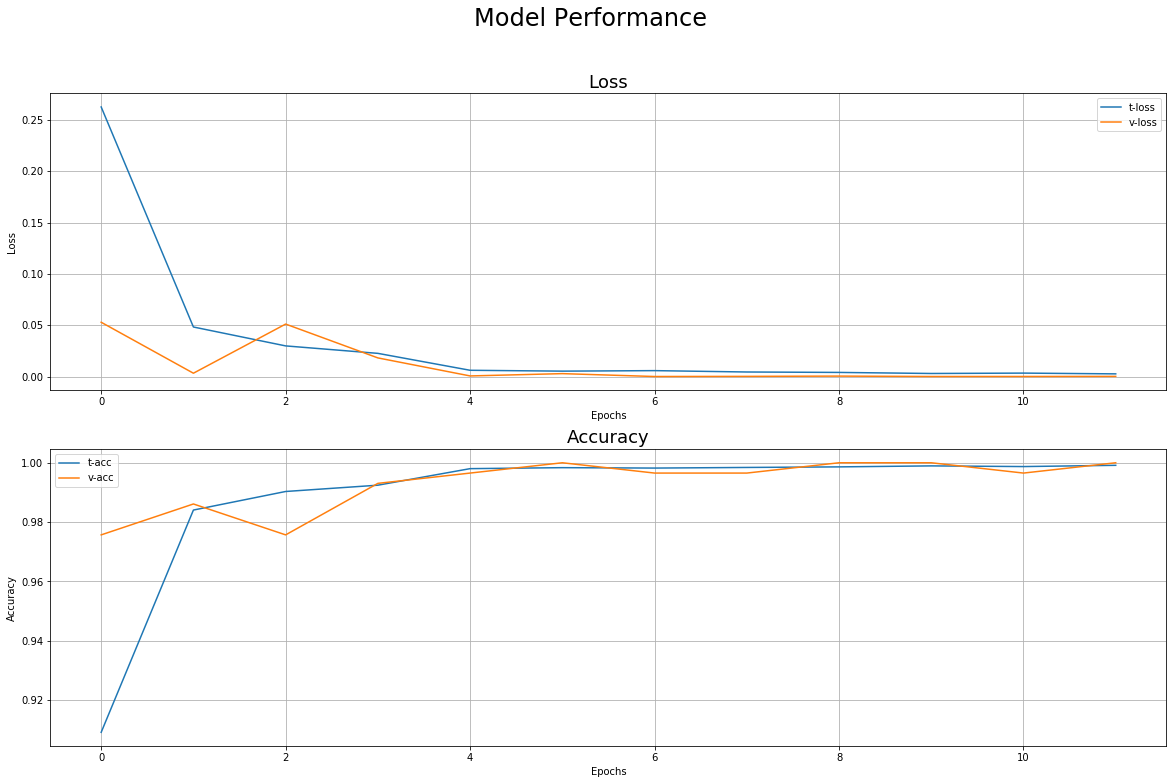

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'], label='t-acc')
ax[1].plot(history.history['val_accuracy'], label='v-acc')
ax[1].set_title('Accuracy', fontsize=18)
ax[1].set_ylabel('Accuracy')


for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    
plt.savefig('history.png')    